In [447]:
import multiprocessing
import re,string
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as shc 
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
#Functionality to turn stemming on or off
STEMMING = True  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 1  # try 1 and 2 and see which yields better modeling results
VECTOR_LENGTH = 100  # set vector length for TF-IDF and Doc2Vec
DISPLAYMAX = 10 # Dispaly count for head() or tail() sorted values
DROP_STOPWORDS = False
SET_RANDOM = 9999
NUMBER_OF_CLUSTERS = 2

In [448]:
##############################################################################
#  Number of cpu cores
##############################################################################
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)



Number of processor cores: 16


In [449]:
#############################################################################
#  Create document labels 
############################################################################
def create_label(text):
    #print(text)
    text = text.replace('.html','')
    #print(text)
    text = text.replace('.htm','')
    regex = re.compile('[^a-zA-Z]')
    regex.sub('', text)
    return text

In [450]:
cluster_dict = {
    0:"safety",
    1:"technology"
}

In [451]:
def createCategory(text):
    if '-safe-' in text:
        return 'safety'
    return 'technology'

In [452]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:   
        lem = WordNetLemmatizer()
        tokens = [lem.lemmatize(token) for token in tokens]
    return tokens

In [453]:
documents=[]
text_body=[]
text_titles = []
categories = []
regex = re.compile('[^a-zA-Z]')
with open('autonomous_vehicles_safety_corpus.jl') as json_file:
     data = json.load(json_file)
     for p in data:
         text_body.append(p['BODY'])
         text_titles.append(p['TITLE'][0:8])
         documents.append(create_label(p['FILENAME']))
         categories.append(createCategory(p['FILENAME']))

In [454]:
################################
# Final Processed File
############################
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

<h3>(2) Using matrices for Approaches 1, 2, and 3, perform partitioned cluster analysis (K-means) 
with documents as objects. Utilize objective methods for determining the number of clusters K. 
Prepare summary lists of documents within each cluster. If there is a large number of documents, 
show a sample of the documents in lists. Describe the results.</h3>

<h5>(2) Approach 1 - CountVectorizer with Kmeans with documents as Objects</h5>

In [455]:
#####################################################################################################
### Count Vectorization
#####################################################################################################
print('\n\t\tCountVectorizer + Kmeans with documents as Objects')

count_vectorizer2A1 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors_matrix2A1 = count_vectorizer2A1.fit_transform(documents)

kmCV2A1 = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=89)
kmCV2A1.fit(count_vectors_matrix2A1)
clustersCv2A1 = kmCV2A1.labels_.tolist()

y1 = clustersCv2A1
X1 = count_vectors_matrix2A1

termsCv2A1 = count_vectorizer2A1.get_feature_names()



		CountVectorizer + Kmeans with documents as Objects


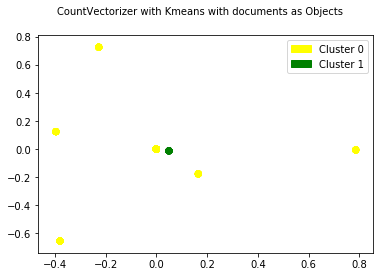

In [456]:
x = count_vectors_matrix2A1.todense()

labels2A2 = kmCV2A1.fit_predict(count_vectors_matrix2A1)

reduced_data = PCA().fit_transform(x)

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

fig = plt.figure()
fig.suptitle('CountVectorizer with Kmeans with documents as Objects', fontsize=10)
cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in labels2A2]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

In [457]:
print("2A1 CountVectorizer + Kmeans with documents as Objects Top documents per cluster:")
order_centroids2A1 = kmCV2A1.cluster_centers_.argsort()[:, ::-1]

for i in range(NUMBER_OF_CLUSTERS):
    top_ten_words2A1 = [termsCv2A1[ind] for ind in order_centroids2A1[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words2A1)))

2A1 CountVectorizer + Kmeans with documents as Objects Top documents per cluster:
Cluster 0: curbanplanning cvehiclegoogle cdriverlesscar cubercities treportdata
Cluster 1: courcities wthisweek treportdata teurope2017 tfooddelivery


<h5>(2) Approach 2 - TF-IDF Vectorization with Kmeans with documents as Objects</h5>


TF-IDF Vectorization with Kmeans with documents as Objects. . .


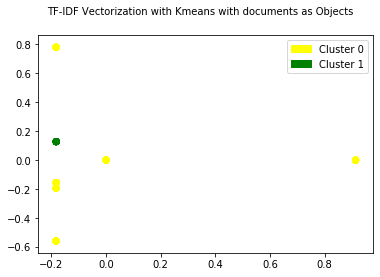

In [458]:
print('\nTF-IDF Vectorization with Kmeans with documents as Objects. . .')
tfidf2A2 = TfidfVectorizer(ngram_range=(1,1), min_df=0.0025)
tfidf2A2_matrix = tfidf2A2.fit_transform(documents)


'''create k-means model with custom config '''
km2A2 = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=89,
                          precompute_distances="auto",n_jobs=-1)

labels2A2 = km2A2.fit_predict(tfidf2A2_matrix)

x = tfidf2A2_matrix.todense()

terms2A2 = tfidf2A2.get_feature_names()
reduced_data = PCA().fit_transform(x)
green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

fig = plt.figure()
fig.suptitle('TF-IDF Vectorization with Kmeans with documents as Objects', fontsize=10)
cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in labels2A2]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

In [459]:
print("2A2 TF-IDF Vectorization with Kmeans with documents as Objects Top documents per cluster:")
order_centroids2A2 = km2A2.cluster_centers_.argsort()[:, ::-1]

for i in range(NUMBER_OF_CLUSTERS):
    top_ten_words2A2 = [terms2A2[ind] for ind in order_centroids2A2[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words2A2)))

2A2 TF-IDF Vectorization with Kmeans with documents as Objects Top documents per cluster:
Cluster 0: cdriverlesscar courcities treportdata curbanplanning cvehiclegoogle
Cluster 1: cubercities wthisweek tdetroit2017 courcities cproscons


<h5>(2) Approach 3 - Doc2Vec Vectorization with Kmeans with documents as Objects</h5>

In [460]:
# train_corpus using TaggedDocument
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

print("\n\t\tDoc2Vec Vectorization with Kmeans with documents as Objects")

# Doc2Vec Vectorization
doc2vec2A3_model = Doc2Vec(vector_size = 50, window = 4, min_count = 2, workers = cores, epochs = 40)
doc2vec2A3_model.build_vocab(train_corpus)
doc2vec2A3_model.train(train_corpus, total_examples = doc2vec2A3_model.corpus_count, epochs = doc2vec2A3_model.epochs)



		Doc2Vec Vectorization with Kmeans with documents as Objects


Doc2vec Vectorization with Kmeans with documents as Objects.


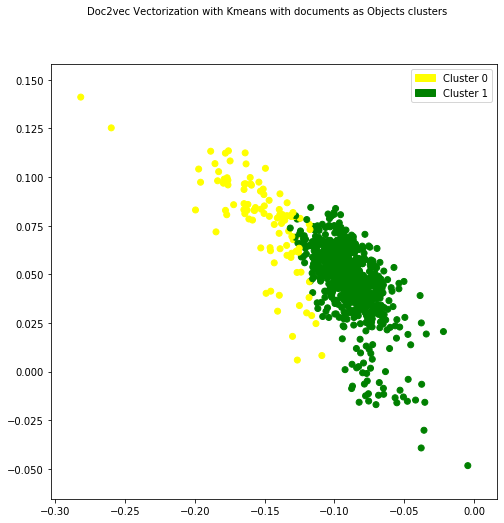

In [461]:
kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
X = kmeans_model.fit(doc2vec2A3_model.docvecs.vectors_docs)
labels2A3=kmeans_model.labels_.tolist()

datapoint = doc2vec2A3_model.docvecs.vectors_docs

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')


print("Doc2vec Vectorization with Kmeans with documents as Objects.")
fig = plt.figure(figsize =(8, 8))
fig.suptitle('Doc2vec Vectorization with Kmeans with documents as Objects clusters', fontsize=10)
cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in labels2A3]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

In [462]:
print("2A3 Doc2vec with Kmeans with documents as Objects Top documents per cluster:")
order_centroids2A3 = kmeans_model.cluster_centers_.argsort()[:, ::-1]

for i in range(NUMBER_OF_CLUSTERS):
    top_ten_words2A3 = [documents[ind] for ind in order_centroids2A3[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words2A3)))

2A3 Doc2vec with Kmeans with documents as Objects Top documents per cluster:
Cluster 0: cproscons wregulatethemselves nvehiclessafety treportdata w2018crash
Cluster 1: cproscons wregulatethemselves nvehiclessafety treportdata w2018crash


<h3>(3) Using matrices for Approaches 1, 2, and 3, perform multidimensional scaling with documents 
as objects. Visualize the multidimensional scaling solutions in two-space, labeling points 
with document names. Identify clusters from the K-means clustering with colored points, providing 
a legend on the visualization. Use t-distributed stochastic neighbor embedding (t-SNE) for the multidimensional scaling. 
If there is a large number of documents, plot a sample of the documents. Describe the results. </h3>

<h5>(3) Approach 1 - CountVectorizer with Kmeans + TSNE with documents as Objects</h5>

In [463]:
print('\n\t\tCountVectorizer + Kmeans + TSNE with documents as Objects')

count_vectorizer3A1 = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors_matrix3A1 = count_vectorizer2A1.fit_transform(documents)

kmCV3A1 = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=89)
kmCV3A1.fit(count_vectors_matrix2A1)


clustersCv3A1 = kmCV2A1.labels_.tolist()
centroids = kmCV3A1.cluster_centers_


		CountVectorizer + Kmeans + TSNE with documents as Objects



TSNE of CountVectorizer  + Kmeans 
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.000s...
[t-SNE] Computed neighbors for 822 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.777046
[t-SNE] KL divergence after 1000 iterations: 1.916307


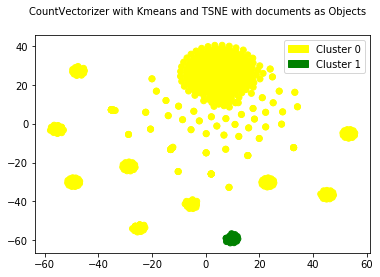

In [464]:
print('\nTSNE of CountVectorizer  + Kmeans ')
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model =  TSNE(n_components=2, verbose=1, perplexity=2.0, n_iter=1000)

transformed_centroids = model.fit_transform(count_vectors_matrix3A1)

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in clustersCv3A1]
fig = plt.figure()
fig.suptitle('CountVectorizer with Kmeans and TSNE with documents as Objects', fontsize=10)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

<h5>(3) Approach 2 -  TF-IDF Vectorizer with Kmeans + TSNE with documents as Objects</h5>

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.001s...
[t-SNE] Computed neighbors for 822 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.392811
[t-SNE] KL divergence after 750 iterations: 0.230274
TF-IDF Vectorizer with Kmeans and TSNE with documents as Objects


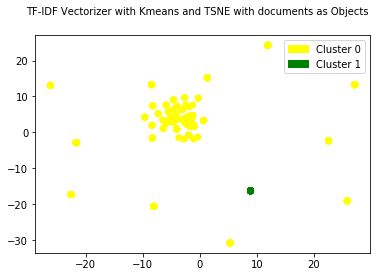

In [465]:
tfidf3A2 = TfidfVectorizer(ngram_range=(1,1), min_df=0.0025)
tfidf3A2_matrix = tfidf2A2.fit_transform(documents)

kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
X = kmeans_model.fit(tfidf3A2_matrix)
labels3A2=kmeans_model.labels_.tolist()


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(tfidf2A2_matrix)

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

print("TF-IDF Vectorizer with Kmeans and TSNE with documents as Objects")
fig = plt.figure()
fig.suptitle('TF-IDF Vectorizer with Kmeans and TSNE with documents as Objects', fontsize=10)
cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in labels3A2]
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

<h5>(3) Approach 3 -  Doc2Vec Vectorizer with Kmeans + TSNE with documents as Objects</h5>

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.006s...
[t-SNE] Computed neighbors for 822 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.024826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.654652
[t-SNE] KL divergence after 1000 iterations: 0.720046
Doc2Vec Vectorization with Kmeans TSNE with documents as Objects.


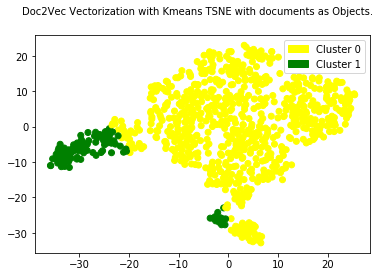

In [466]:
import matplotlib.patches as mpatches
kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
X = kmeans_model.fit(doc2vec2A3_model.docvecs.vectors_docs)
labels2A3=kmeans_model.labels_.tolist()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
datapoint = tsne.fit_transform(doc2vec2A3_model.docvecs.vectors_docs)

print("Doc2Vec Vectorization with Kmeans TSNE with documents as Objects.")
plt.figure
cluster_colors = ["#FFFF00", "#008000"]

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')
fig = plt.figure()
fig.suptitle('Doc2Vec Vectorization with Kmeans TSNE with documents as Objects.', fontsize=10)
color = [cluster_colors[i] for i in labels2A3]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

<h3>(5) Using matrices for Approaches 1 and 2, perform multidimensional scaling (t-SNE) with terms as objects. 
Visualize the multidimensional scaling solutions in 
two-space, labeling points as terms. Describe the results.</h3>

<h5>Approach 1: Count Vectorization with K-Means + TSNE Terms as objects</h5>

In [467]:
# Count Vectorization
print('\n\t\tCount Vectorization with K-Means + TSNE Terms as objects')

count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors_matrix = count_vectorizer.fit_transform(final_processed_text)
kmCV = KMeans(n_clusters=2, random_state=89)
kmCV.fit(count_vectors_matrix)
clustersCv = kmCV.labels_.tolist()

y1 = clustersCv
X1 = count_vectors_matrix

termsCv = count_vectorizer.get_feature_names()



		Count Vectorization with K-Means + TSNE Terms as objects


In [468]:
cv_dictionary = {'FileName':documents, 'Cluster':clustersCv,  'Text': final_processed_text}
cv_df = pd.DataFrame(cv_dictionary, columns=['Cluster', 'FileName','Text'])
cv_df['Category'] = ((cv_df.Cluster)).map(cluster_dict)
    
cv_df

,Cluster,FileName,Text,Category
0,1,nvehiclessafety,driver assistance technology motor vehicle alr...,technology
1,0,wmostmiles,time human safety operator control selfdriving...,safety
2,0,wdrivingcars,since internet search company named google beg...,safety
3,0,wunpredictablehumans,happen city company testing selfdriving probab...,safety
4,1,cproscons,ushering decreased ownership narrowing street ...,technology
...,...,...,...,...
817,0,cgrantdevelopment,filed underthe uniquely positioned need strate...,safety
818,0,ccompanyfuture,filed underflying taxi busesthere splashy anno...,safety
819,0,coakridge,filed underhow knoxville environs became hotsp...,safety
820,0,cshuttledriverless,filed undercolumbus launch downtown driverless...,safety


In [469]:
print("Top Terms for CountVectorizer Kmeans per cluster:")

#sort cluster centers by proximity to centroid
order_centroidsCV = kmCV.cluster_centers_.argsort()[:, ::-1]

terms_dict1 = []
cluster_terms1 = {}
cluster_title1 = {}

for i in range(2):    
    print("Cluster %d:" % i),    
    temp_terms1 = []    
    temp_titles1 = []    
    for ind in order_centroidsCV[i, :10]:        
        print(' %s' % termsCv[ind])        
        terms_dict1.append(termsCv[ind])        
        temp_terms1.append(termsCv[ind])    
    cluster_terms1[i] = temp_terms1   

Top Terms for CountVectorizer Kmeans per cluster:
Cluster 0:
 vehicle
 selfdriving
 company
 autonomous
 technology
 testing
 safety
 public
 driver
 waymo
Cluster 1:
 vehicle
 safety
 selfdriving
 technology
 autonomous
 crash
 automated
 driver
 human
 company



TSNE of CountVectorizer  + Kmeans 
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.000s...
[t-SNE] Computed neighbors for 822 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.571724
[t-SNE] KL divergence after 1000 iterations: 1.007104


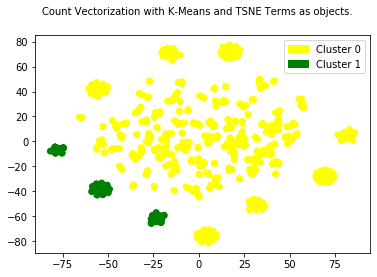

In [470]:
print('\nTSNE of CountVectorizer  + Kmeans ')
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model =  TSNE(n_components=2, verbose=1, perplexity=2.0, n_iter=1000)

cv_transformed_centroids = model.fit_transform(count_vectors_matrix)

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in clustersCv]
fig = plt.figure()
fig.suptitle('Count Vectorization with K-Means and TSNE Terms as objects.', fontsize=10)
plt.scatter(cv_transformed_centroids[:, 0], cv_transformed_centroids[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

<h4>Approach 2: TF-IDF Vectorization with K-Means + TSNE Terms as objects</h4>

In [471]:
##############################
### TF-IDF Vectorization
##############################
# run tfidf (prevalent - require 25% of docs)

print('\nTF-IDF Vectorization K Means vectorization. . .')

tfidf1 = TfidfVectorizer(ngram_range=(1,1))
tfidf1_matrix = tfidf1.fit_transform(final_processed_text)

k=2
km2 = KMeans(n_clusters=k, random_state=89)
km2.fit(tfidf1_matrix)
clusters1 = km2.labels_.tolist()


terms2 = tfidf1.get_feature_names()


TF-IDF Vectorization K Means vectorization. . .


In [472]:
tf1_dictionary = {'FileName':documents, 'Cluster':clusters1,  'Text': final_processed_text}
tf1_df = pd.DataFrame(tf1_dictionary, columns=['Cluster', 'FileName','Text'])
tf1_df['Category'] = ((tf1_df.Cluster)).map(cluster_dict)
    
tf1_df.tail(5)

,Cluster,FileName,Text,Category
817,0,cgrantdevelopment,filed underthe uniquely positioned need strate...,safety
818,0,ccompanyfuture,filed underflying taxi busesthere splashy anno...,safety
819,0,coakridge,filed underhow knoxville environs became hotsp...,safety
820,0,cshuttledriverless,filed undercolumbus launch downtown driverless...,safety
821,0,cdrinkright,filed featuring thing place visit around world...,safety


In [473]:
print("Top Terms per TF_IDF Kmeans cluster:")

#sort cluster centers by proximity to centroid
order_centroids2 = km2.cluster_centers_.argsort()[:, ::-1]

terms_dict2 = []
cluster_terms2 = {}
cluster_title2 = {}

for i in range(k):    
    print("Cluster %d:" % i),    
    temp_terms2 = []    
    temp_titles2 = []    
    for ind in order_centroids2[i, :10]:        
        print(' %s' % terms2[ind])        
        terms_dict2.append(terms2[ind])        
        temp_terms2.append(terms2[ind])    
    cluster_terms2[i] = temp_terms2   

Top Terms per TF_IDF Kmeans cluster:
Cluster 0:
 vehicle
 selfdriving
 autonomous
 company
 safety
 waymo
 technology
 testing
 driver
 human
Cluster 1:
 parking
 space
 garage
 empty
 people
 development
 urban
 planning
 tierney
 vehicle



TSNE of TF-IDF Vectorizer  + Kmeans 
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.001s...
[t-SNE] Computed neighbors for 822 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.936440
[t-SNE] KL divergence after 1000 iterations: 1.007861


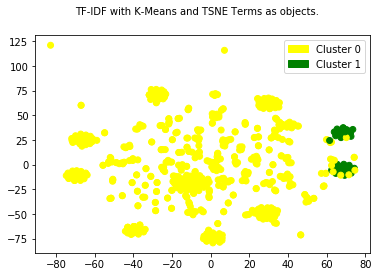

In [474]:
print('\nTSNE of TF-IDF Vectorizer  + Kmeans ')
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model =  TSNE(n_components=2, verbose=1, perplexity=2.0, n_iter=1000)

tf_idf_transformed_centroids = model.fit_transform(tfidf1_matrix)

green_patch = mpatches.Patch(color="#FFFF00", label='Cluster 0')
yellow_patch = mpatches.Patch(color='#008000', label='Cluster 1')

cluster_colors = ["#FFFF00", "#008000"]
color = [cluster_colors[i] for i in clusters1]
fig = plt.figure()
fig.suptitle('TF-IDF with K-Means and TSNE Terms as objects.', fontsize=10)
plt.scatter(tf_idf_transformed_centroids[:, 0], tf_idf_transformed_centroids[:, 1], c=color)
plt.legend(handles=[green_patch, yellow_patch])
plt.show()

<h5>(6) Using matrices for Approaches 1 and 2, perform hierarchical cluster analysis with terms as objects. 
Visualize the clustering solution as a tree diagram, with terminal nodes labeled as terms. Describe the results.</h5>

<h5>Approach 1: Count Vectorized Hierarachial clustering with Terms as objects</h5>

In [475]:
X = count_vectors_matrix.todense()

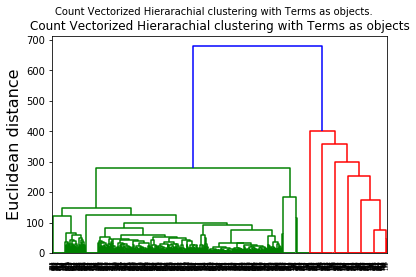

In [476]:
fig = plt.figure() 
fig.suptitle('Count Vectorized Hierarachial clustering with Terms as objects.', fontsize=10)
plt.title('Count Vectorized Hierarachial clustering with Terms as objects') 
plt.ylabel('Euclidean distance', fontsize=16)
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward'))) 

<h5>Approach 2: TF-IDF Vectorized Hierarachial clustering with Terms as objects</h5>

In [477]:
X = tfidf1_matrix.todense()

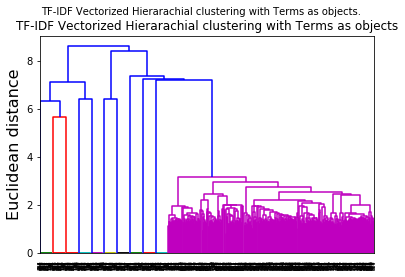

In [478]:
fig = plt.figure() 
fig.suptitle('TF-IDF Vectorized Hierarachial clustering with Terms as objects.', fontsize=10)
plt.title('TF-IDF Vectorized Hierarachial clustering with Terms as objects') 
plt.ylabel('Euclidean distance', fontsize=16)
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward'))) 

<h5>(7) Compare multidimensional scaling and clustering results for terms across Approaches 1 and 2. 
What do these analyses tell you about the corpus? In your opinion, which of the two approaches provides 
the most clear-cut (interpretable) results?</h5>

<h3>(9, optional) Try a topic modeling solution such as latent Dirichlet allocation to identify documents with topics: 
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
</h3>

In [479]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

<h4>CountVectorizer +  LatentDirichletAllocation </h4>

In [480]:
cv_lda = LatentDirichletAllocation(max_iter=20, learning_method='online', \
                                learning_offset=50.,random_state=89).fit(count_vectors_matrix)

In [481]:
print("CountVectorizer + LatentDirichletAllocation ")
no_top_words = 10
cv_feature_names = count_vectorizer.get_feature_names()
display_topics(cv_lda, cv_feature_names, no_top_words)

CountVectorizer + LatentDirichletAllocation 
Topic 0:
would software vehicle engineer people company could selfdriving going potential
Topic 1:
space parking people vehicle design city public house urban transportation
Topic 2:
vehicle safety technology automated autonomous transportation driver crash human fully
Topic 3:
driver system tesla electric company vehicle would thing around might
Topic 4:
selfdriving vehicle safety driving technology company people human level would
Topic 5:
company selfdriving software project would engineer year could google might
Topic 6:
waymo program selfdriving around number service company system without human
Topic 7:
federal people engineer design road electric street might percent safer
Topic 8:
vehicle autonomous selfdriving company testing mile california street safety arizona
Topic 9:
selfdriving company waymo autonomous vehicle google sensor service lidar first


In [482]:
print('CountVectorizer seems to have produced better results than the Tf-IDF LDA example')

CountVectorizer seems to have produced better results than the Tf-IDF LDA example


<h4>Tf-IDF +  LatentDirichletAllocation </h4>

In [483]:
tf_idf_lda = LatentDirichletAllocation(max_iter=20, learning_method='online', \
                                learning_offset=50.,random_state=89).fit(tfidf1_matrix)

In [484]:
print("Tf-IDF + LatentDirichletAllocation ")
no_top_words = 10
tf_feature_names = tfidf1.get_feature_names()
display_topics(tf_idf_lda, tf_feature_names, no_top_words)

Tf-IDF + LatentDirichletAllocation 
Topic 0:
vehicle lidar selfdriving safety driver luminar quartermile fuelcell university exposed
Topic 1:
disengagement vehicle mile driver drove testing selfdriving company autonomous registered
Topic 2:
vehicle automated safety selfdriving human waymo driver technology crash tesla
Topic 3:
vehicle selfdriving autonomous company safety technology waymo testing driver public
Topic 4:
concept driverless future model vehicle technology screen automaker towards integrating
Topic 5:
vehicle noticed competes garage wearable warning selfdriving novelizing tesla stone
Topic 6:
upcoming ioniq familyfocused form dispatcher shifted canceling displayed eliza mcclintock
Topic 7:
chaser hackett company neverthe wavering autonomous accused waymo stroke forgettable
Topic 8:
parking people space salesky could viability vehicle daylong needed profession
Topic 9:
cameraequipped waymoapproved fundjust commenting rejigger obtaining provide fumble expired levittowns
